# Subalpine shrubs notebook

The data was downloaded from [here](https://zenodo.org/record/8266948), while the original paper code can be found [here](https://github.com/nicill/ZaoShrubDL).

Koma Moritake, Mariano Cabezas, Tran Thi Cam Nhung, Maximo Larry Lopez Caceres, Yago Diez. [*Sub-alpine shrub classification using UAV images: Performance of human observers vs DL classifiers*](https://doi.org/10.1016/j.ecoinf.2024.102462). **Ecological Informatics, 80**. (2024)

## Class description:
- **Label: 0** (Background)
- **Label: 1** (Ilex Crenata)
- **Label: 2** (Acer Tchonoskii)
- **Label: 3** (Taxus Cuspidata)
- **Label: 4** (Pinus spp)
- **Label: 5** (Sorbus Commixta)
- **Label: 6** (Cerasus Nipponica)

## Channel description:

- **Channel: 1** (Red - R)
- **Channel: 2** (Green - G)
- **Channel: 3** (Blue - B)

## Python requirements:
- pytorch 1.12.0
- torchvision 0.13.0

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

from PIL import Image
import tifffile as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import numpy as np
from skimage import io as skio
from scipy.special import expit, softmax
from scipy import ndimage as nd

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as func

from datasets import MosaicDataset, BalancedMosaicDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, time_to_string, normalise
from experiments import run_segmentation_experiments, run_classification_experiments

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects), sklearn (and its image analysis extension) and opencv (for image tools). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Data preparation
This is a structured dataset where a set of image mosaics and a set of treetops (6 classes) are stored in PNG files. In that sense, neither segmentation, nor classification labels are provided. Therefore, we will define bounding boxes for each tree as patches centered around the tree top and focus on a patch classification approach. On the next cell we load the mosaic, ROI and labels; and plot them. The mosaic are large and plotting the images might take some time (and memory resources). To skip visualisation, we included a variable that is checked when running the cell. 

We also introduce a utility function (```seg_to_rgb(segmentation, colors)```) to convert segmentations to RGB images to be visualised through matplotlib. We conveniently mapped each label to a color using binary definitions (we have 6 classes).

In [2]:
def seg_to_rgb(segmentation, colors):
    rgb_mask = np.zeros(segmentation.shape + (3,))
    for i, c in enumerate(colors):
        c_mask = segmentation == (i + 1)
        rgb_mask[c_mask, :] = c
    return rgb_mask

In [3]:
visualisation = False

colors = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
])

d_path = '/home/mariano/data/Wetlands/SubalpineBushes/'
mosaic_file = 'site5_mosaic.jpg'
mosaic_ROI = 'site5_ROI.png'
labels_list = sorted([
    f for f in os.listdir(d_path)
    if f.endswith('mask.png')
])

mosaic = cv2.imread(
    os.path.join(d_path, mosaic_file)
)[..., ::-1]
roi = cv2.imread(
    os.path.join(d_path, mosaic_ROI)
)[..., 0] < 128
mask = np.max([
    (i + 1) * (cv2.imread(
        os.path.join(d_path, f)
    )[..., 0] < 128).astype(np.uint8)
    for i, f in enumerate(labels_list)
], axis=0)

if visualisation:
    plt.figure(figsize=(30, 50))
    plt.subplot(1, 2, 1)
    plt.imshow(mosaic)
    plt.imshow(roi.astype(np.float32), alpha=0.5, cmap='jet')
    plt.subplot(1, 2, 2)
    plt.imshow(mosaic)
    plt.imshow(seg_to_rgb(mask, colors).astype(np.float32), alpha=0.5)

For the next cell we will randomly crop a few patches to better see the mosaic and label information. We will also be using utility function (```random_patch(mosaic, labels, roi, patch_size)```) to randomly select a patch inside the ROI.

In [4]:
def random_patch(mosaic, labels, roi, patch_size):
    im_y, im_x, _ = mosaic.shape
    y_idx, x_idx = np.where(roi)
    
    centre = np.random.randint(len(x_idx))
    cx = np.clip(x_idx[centre], patch_size // 2, im_x - patch_size // 2)
    cy = np.clip(y_idx[centre], patch_size // 2, im_y - patch_size // 2)
    ini_x, ini_y = (cx - patch_size // 2, cy - patch_size // 2)
    end_x, end_y = (ini_x + patch_size, ini_y + patch_size)
    patch = mosaic[ini_y:end_y, ini_x:end_x, :]
    patch_seg = labels[ini_y:end_y, ini_x:end_x]
    patch_roi = roi[ini_y:end_y, ini_x:end_x]
    return patch, patch_seg

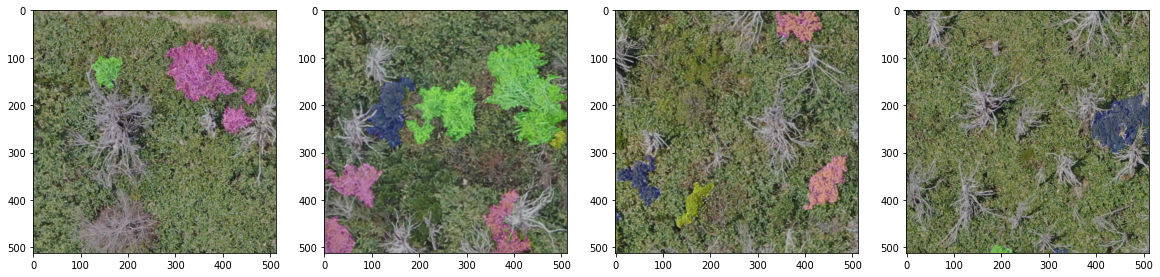

In [5]:
patch_size = 512

patch_1, seg_1 = random_patch(mosaic, mask, roi, patch_size)
patch_2, seg_2 = random_patch(mosaic, mask, roi, patch_size)
patch_3, seg_3 = random_patch(mosaic, mask, roi, patch_size)
patch_4, seg_4 = random_patch(mosaic, mask, roi, patch_size)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(patch_1)
plt.imshow(seg_to_rgb(seg_1, colors).astype(np.float32), alpha=0.25)
plt.subplot(1, 4, 2)
plt.imshow(patch_2)
plt.imshow(seg_to_rgb(seg_2, colors).astype(np.float32), alpha=0.25)
plt.subplot(1, 4, 3)
plt.imshow(patch_3)
plt.imshow(seg_to_rgb(seg_3, colors).astype(np.float32), alpha=0.25)
plt.subplot(1, 4, 4)
plt.imshow(patch_4)
plt.imshow(seg_to_rgb(seg_4, colors).astype(np.float32), alpha=0.25)

Finally, we divide the mosaic in two trying to be as balanced as possible in the following cell.

In [6]:
roi_idx = np.where(roi)
bb = tuple(
    slice(min_i, max_i)
    for min_i, max_i in zip(
        np.min(roi_idx, axis=-1),
        np.max(roi_idx, axis=-1),
    )
)
cropped_mosaic = mosaic[bb + (slice(None),)]
cropped_roi = roi[bb]
cropped_mask = mask[bb]

if visualisation:
    plt.figure(figsize=(30, 50))
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_mosaic)
    plt.imshow(cropped_roi.astype(np.float32), alpha=0.5, cmap='jet')
    plt.subplot(1, 2, 2)
    plt.imshow(cropped_mosaic)
    plt.imshow(seg_to_rgb(cropped_mask, colors).astype(np.float32), alpha=0.5)

In [7]:
im_y, im_x, _ = cropped_mosaic.shape
x_cutoff = (im_x // 2)
y_cutoff = (im_y // 2)
training_mosaic = cropped_mosaic[:, :x_cutoff, :]
training_mask = cropped_mask[:, :x_cutoff]
training_roi = cropped_roi[:, :x_cutoff]

testing_mosaic = cropped_mosaic[:, x_cutoff:, :]
testing_mask = cropped_mask[:, x_cutoff:]
testing_roi = cropped_roi[:, x_cutoff:]

labels = [
    f.split('.')[0].split('_')[1].capitalize()
    for f in labels_list
]

all_train = np.sum(training_mask > 0)
all_test = np.sum(testing_mask > 0)
for i, k in enumerate(labels):
    train_k = np.sum(training_mask == (i + 1)) 
    test_k = np.sum(testing_mask == (i + 1)) 
    print(
        'Class ({:d}) {:}: {:.3f} ({:.2f}) / {:.3f} ({:.2f})'.format(
            i + 1, k, train_k, 100 * train_k / all_train,
            test_k, 100 * test_k / all_test,
        )
    )
if visualisation:
    plt.figure(figsize=(30, 50))
    plt.subplot(1, 4, 1)
    plt.imshow(training_mosaic)
    plt.imshow(training_roi.astype(np.float32), alpha=0.5, cmap='jet')
    plt.subplot(1, 4, 2)
    plt.imshow(testing_mosaic)
    plt.imshow(testing_roi.astype(np.float32), alpha=0.5, cmap='jet')
    plt.subplot(1, 4, 3)
    plt.imshow(training_mosaic)
    plt.imshow(seg_to_rgb(training_mask, colors).astype(np.float32), alpha=0.5)
    plt.subplot(1, 4, 4)
    plt.imshow(testing_mosaic)
    plt.imshow(seg_to_rgb(testing_mask, colors).astype(np.float32), alpha=0.5)

Class (1) Inutsuge: 135733.000 (2.50) / 220194.000 (6.01)
Class (2) Kaede: 1144148.000 (21.09) / 519866.000 (14.20)
Class (3) Kyaraboku: 1263840.000 (23.29) / 1255304.000 (34.28)
Class (4) Matsu: 394531.000 (7.27) / 320332.000 (8.75)
Class (5) Nanakamado: 2146603.000 (39.56) / 957001.000 (26.13)
Class (6) Sakura: 340992.000 (6.28) / 389497.000 (10.64)


# Main function (segmentation)
The following cell contains the code to run all the experiments for the dataset. It heavily relies on a function that we imported on the first cell that we briefly describe here:

```python
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f,
    training_set, validation_set, testing_data, weight_path, maps_path,
    classes=None, patch_size=None, epochs=10, patience=5, n_seeds=30,
    n_inputs=3, n_classes=2, train_batch=20, test_batch=50, verbose=1
)
```

This is the main function involved in the experimentation process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore, a **network_name** is required for the weights file while a **display_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained. The **classes** variable with a list of the class names and the **experiment_name** variables are also used to display messages regarding the results and experiment type.

For training and testing, a tuple of lists containing the images and masks are required as **training_data** and **testing_data** for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.

In [8]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

master_seed = 42

train_batch = 8
test_batch = 16
patch_size = 256
overlap = 16
epochs = 50
patience = 50
name = 'subalpine'
classes = ['Background'] + labels
print(classes)

image_path = os.path.join(
    d_path, 'Predictions', 'testing_image.png'
)
skio.imsave(image_path, testing_mosaic.astype(np.uint8))
mask_path = os.path.join(
    d_path, 'Predictions', 'testing_mask.png'
)
skio.imsave(mask_path, (255 * testing_mask).astype(np.uint8))

testing_data = (
    [np.moveaxis(testing_mosaic[..., :3], -1, 0)],
    [testing_mask.astype(np.uint8)]
)

# While we use a BalancedMosaicDataset for training, it might
# be a good idea to also use MosaicDataset. The choice of dataset
# should be coherent with what we do on the other datasets.  
training_set = BalancedMosaicDataset(
    [np.moveaxis(training_mosaic[..., :3], -1, 0)],
    [training_mask.astype(np.uint8)], patch_size, overlap
)
validation_set = MosaicDataset(
    [np.moveaxis(training_mosaic[..., :3], -1, 0)],
    [training_mask.astype(np.uint8)], patch_size, overlap
)

# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # Unet [64, 64, 256, 256, 512, 512]
    unet_dsc, unet_k_dsc = run_segmentation_experiments(
        master_seed, 'unet2d', 'Unet 2D', name,
        partial(Unet2D, lr=1e-4, conv_filters=[64, 64, 256, 256, 512, 512]),
        training_set, validation_set, testing_data,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=len(classes), epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, verbose=1
    )
    
    # FCN ResNet50
    fcn50_dsc, fcn50_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet50', 'FCN ResNet50', name,
        partial(FCN_ResNet50, lr=1e-4, pretrained=True),
        training_set, validation_set, testing_data,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=len(classes), epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, verbose=1
    )
    
    # FCN ResNet101
    fcn101_dsc, fcn101_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet101', 'FCN ResNet101', name,
        partial(FCN_ResNet101, lr=1e-4, pretrained=True),
        training_set, validation_set, testing_data,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=len(classes), epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, verbose=1
    )

    # DeeplapV3 MobileNet
    dl3mn_dsc, dl3mn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-mobilenet', 'DeeplabV3 MobileNet', name,
        partial(DeeplabV3_MobileNet, lr=1e-4, pretrained=True),
        training_set, validation_set, testing_data,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=len(classes), epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, verbose=1
    )

    # DeeplapV3 ResNet50
    dl3rn_dsc, dl3rn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-resnet50', 'DeeplabV3 ResNet50', name,
        partial(DeeplabV3_ResNet50, lr=1e-4, pretrained=True),
        training_set, validation_set, testing_data,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=len(classes), epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, verbose=1
    )

    # L-RASPP ResNet50
    lraspp_dsc, lraspp_k_dsc = run_segmentation_experiments(
        master_seed, 'lraspp-mobilenet', 'Lite R-ASPP MobileNet', name,
        partial(LRASPP_MobileNet, lr=1e-4, pretrained=True),
        training_set, validation_set, testing_data,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=len(classes), epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, verbose=1
    )

['Background', 'Inutsuge', 'Kaede', 'Kyaraboku', 'Matsu', 'Nanakamado', 'Sakura']
[02/08/2024 - 22:14:05] Unet 2D Mean DSC 0.172                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
[02/08/2024 - 22:14:05] Unet 2D Mean class DSC Background 0.960, Inutsuge 0.000, Kaede 0.000, Kyaraboku 0.200, Matsu 0.021, Nanakamado 0.026, Sakura 0.000
[02/09/2024 - 00:58:39] FCN ResNet50 Mean DSC 0.196                                                                                                                                                          

# Main functions (classification)
The following cell uses two main functions that will be used to run all the experiments for the dataset.

```python
def run_classification_experiments(
    master_seed, network_name, display_name, name, network,
    training_set, testing_set, weight_path, classes=None,
    epochs=10, patience=5, n_seeds=30, n_classes=2,
    train_batch=20, test_batch=50, verbose=1
)
```

This is the main function involved in the classification process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore a **network_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained, together with the required lists of **training_files** and **testing_files** with the name of the images containing the mosaic for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.

```python
def run_attribution_experiments(
    master_seed, network_name, network, testing_files, weight_path, maps_path,
    n_seeds=30, n_classes=2, saliency_batch=4, verbose=1
)
```

This first function uses a wrapper function(```attribution(x, attr_m, *args, **kwargs)```) for the generation of a final saliency map based on the output of the relevant Captum method and the input image (**x**). Depending on the attribution method, the map might be unbounded or have a different size than the original image. To fix that and provide a storable image, the necessary transformations are applied. Since the function acts as a wrapper and the attribution method (**attr_m**) might require additional parameters, we need **args** and **kwargs** as input parameters that are then passed to the attribution method as either a list or a dictionary of arguments, respectively.

Regarding the main function, it follows a similar structure to our other main functions with **master_seed**, **n_seeds**, **n_classes**, **network_name**, **network**, **weight_path** and **maps_path** being the same variables we use for the other tasks (segmentation and classification). The only addition is **saliency_batch** which is used to define how many images we are going to compute maps for in parallel (similar to to **test_batch** on the other functions).